In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed and style
np.random.seed(42)


In [5]:
merged_data = pd.read_csv("merged_data.csv")

print("Dataset Overview:")
print("-----------------")
print(f"Total Records: {len(merged_data)}")
print("\nColumns in dataset:")
print(merged_data.columns.tolist())
print("\nSample data:")
merged_data.head()

Dataset Overview:
-----------------
Total Records: 1000

Columns in dataset:
['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region', 'SignupDate', 'ProductName', 'Category', 'Price_y']

Sample data:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


Created features:
['CustomerID', 'Total_Spend', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Total_Quantity', 'Avg_Quantity', 'Std_Quantity', 'Unique_Products', 'Transaction_Count', 'Days_on_Platform', 'Books', 'Clothing', 'Electronics', 'Home Decor', 'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America']


,CustomerID,Total_Spend,Avg_Transaction_Value,Std_Transaction_Value,Total_Quantity,Avg_Quantity,Std_Quantity,Unique_Products,Transaction_Count,Days_on_Platform,Books,Clothing,Electronics,Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,456.643861,12,2.400000,0.547723,5,5,932,0.166667,0.000000,0.583333,0.250000,False,False,False,True
1,C0002,1862.74,465.685,219.519169,10,2.500000,1.000000,4,4,1079,0.000000,0.400000,0.000000,0.600000,True,False,False,False
2,C0003,2725.38,681.345,559.276543,14,3.500000,0.577350,4,4,326,0.000000,0.285714,0.285714,0.428571,False,False,False,True
3,C0004,5354.88,669.360,325.386829,23,2.875000,1.125992,8,8,841,0.347826,0.000000,0.260870,0.391304,False,False,False,True
4,C0005,2034.24,678.080,310.820746,7,2.333333,0.577350,3,3,896,0.000000,0.000000,0.571429,0.428571,True,False,False,False


In [7]:
features = customer_data.drop('CustomerID', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("Features scaled. Shape:", features_scaled.shape)

Features scaled. Shape: (199, 17)


In [9]:
# Cell 3: Modified Data Preprocessing Function
def create_customer_features(merged_data):
    """
    Create customer features from merged transaction and customer data with NaN handling
    """
    # Transaction-based features
    customer_profile = merged_data.groupby("CustomerID").agg({
        "TotalValue": ["sum", "mean", "std"],
        "Quantity": ["sum", "mean", "std"],
        "ProductID": "nunique",
        "TransactionID": "count"
    }).reset_index()
    
    # Flatten column names
    customer_profile.columns = [
        "CustomerID", "Total_Spend", "Avg_Transaction_Value", "Std_Transaction_Value",
        "Total_Quantity", "Avg_Quantity", "Std_Quantity", "Unique_Products", "Transaction_Count"
    ]
    
    # Replace infinite values with NaN
    customer_profile = customer_profile.replace([np.inf, -np.inf], np.nan)
    
    # Customer demographics
    customer_demographics = merged_data.groupby("CustomerID").agg({
        "Region": "first",
        "SignupDate": "first"
    }).reset_index()
    
    # Calculate customer age on platform
    customer_demographics["SignupDate"] = pd.to_datetime(customer_demographics["SignupDate"])
    reference_date = pd.to_datetime("2025-01-27 18:48:22")  # Using provided timestamp
    customer_demographics["Days_on_Platform"] = (
        reference_date - customer_demographics["SignupDate"]
    ).dt.days
    
    # Category preferences
    category_pivot = pd.crosstab(
        merged_data["CustomerID"], 
        merged_data["Category"], 
        values=merged_data["Quantity"],
        aggfunc="sum",
        normalize="index"
    ).fillna(0)  # Fill NaN with 0 for category preferences
    
    # Combine all features
    final_profile = customer_profile.merge(
        customer_demographics[["CustomerID", "Region", "Days_on_Platform"]], 
        on="CustomerID"
    )
    
    final_profile = final_profile.merge(
        category_pivot, 
        left_on="CustomerID",
        right_index=True
    )
    
    # Encode categorical variables
    final_profile_encoded = pd.get_dummies(final_profile, columns=["Region"])
    
    return final_profile_encoded

# Preprocess data
customer_data = create_customer_features(merged_data)
print("\nChecking for missing values:")
print(customer_data.isnull().sum())
print("\nCreated features:")
print(customer_data.columns.tolist())
customer_data.head()


Checking for missing values:
CustomerID                0
Total_Spend               0
Avg_Transaction_Value     0
Std_Transaction_Value    12
Total_Quantity            0
Avg_Quantity              0
Std_Quantity             12
Unique_Products           0
Transaction_Count         0
Days_on_Platform          0
Books                     0
Clothing                  0
Electronics               0
Home Decor                0
Region_Asia               0
Region_Europe             0
Region_North America      0
Region_South America      0
dtype: int64

Created features:
['CustomerID', 'Total_Spend', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Total_Quantity', 'Avg_Quantity', 'Std_Quantity', 'Unique_Products', 'Transaction_Count', 'Days_on_Platform', 'Books', 'Clothing', 'Electronics', 'Home Decor', 'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America']


,CustomerID,Total_Spend,Avg_Transaction_Value,Std_Transaction_Value,Total_Quantity,Avg_Quantity,Std_Quantity,Unique_Products,Transaction_Count,Days_on_Platform,Books,Clothing,Electronics,Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,456.643861,12,2.400000,0.547723,5,5,932,0.166667,0.000000,0.583333,0.250000,False,False,False,True
1,C0002,1862.74,465.685,219.519169,10,2.500000,1.000000,4,4,1079,0.000000,0.400000,0.000000,0.600000,True,False,False,False
2,C0003,2725.38,681.345,559.276543,14,3.500000,0.577350,4,4,326,0.000000,0.285714,0.285714,0.428571,False,False,False,True
3,C0004,5354.88,669.360,325.386829,23,2.875000,1.125992,8,8,841,0.347826,0.000000,0.260870,0.391304,False,False,False,True
4,C0005,2034.24,678.080,310.820746,7,2.333333,0.577350,3,3,896,0.000000,0.000000,0.571429,0.428571,True,False,False,False


In [10]:
# Cell 1 - 2 remain the same as before

# Cell 3: Modified Data Preprocessing Function
def create_customer_features(merged_data):
    """
    Create customer features with proper handling of single-transaction customers
    """
    # Transaction-based features
    customer_profile = merged_data.groupby("CustomerID").agg({
        "TotalValue": ["sum", "mean", "std"],
        "Quantity": ["sum", "mean", "std"],
        "ProductID": "nunique",
        "TransactionID": "count"
    }).reset_index()
    
    # Flatten column names
    customer_profile.columns = [
        "CustomerID", "Total_Spend", "Avg_Transaction_Value", "Std_Transaction_Value",
        "Total_Quantity", "Avg_Quantity", "Std_Quantity", "Unique_Products", "Transaction_Count"
    ]
    
    # Fill NaN values in standard deviation columns with 0 for single-transaction customers
    customer_profile['Std_Transaction_Value'] = customer_profile['Std_Transaction_Value'].fillna(0)
    customer_profile['Std_Quantity'] = customer_profile['Std_Quantity'].fillna(0)
    
    # Customer demographics
    customer_demographics = merged_data.groupby("CustomerID").agg({
        "Region": "first",
        "SignupDate": "first"
    }).reset_index()
    
    # Calculate customer age on platform
    customer_demographics["SignupDate"] = pd.to_datetime(customer_demographics["SignupDate"])
    reference_date = pd.to_datetime("2025-01-27 18:51:37")  # Updated timestamp
    customer_demographics["Days_on_Platform"] = (
        reference_date - customer_demographics["SignupDate"]
    ).dt.days
    
    # Category preferences
    category_pivot = pd.crosstab(
        merged_data["CustomerID"], 
        merged_data["Category"], 
        values=merged_data["Quantity"],
        aggfunc="sum",
        normalize="index"
    ).fillna(0)
    
    # Combine all features
    final_profile = customer_profile.merge(
        customer_demographics[["CustomerID", "Region", "Days_on_Platform"]], 
        on="CustomerID"
    )
    
    final_profile = final_profile.merge(
        category_pivot, 
        left_on="CustomerID",
        right_index=True
    )
    
    # Encode categorical variables
    final_profile_encoded = pd.get_dummies(final_profile, columns=["Region"])
    
    return final_profile_encoded

# Preprocess data
customer_data = create_customer_features(merged_data)
print("\nChecking for missing values after preprocessing:")
print(customer_data.isnull().sum())
print("\nCreated features:")
print(customer_data.columns.tolist())


Checking for missing values after preprocessing:
CustomerID               0
Total_Spend              0
Avg_Transaction_Value    0
Std_Transaction_Value    0
Total_Quantity           0
Avg_Quantity             0
Std_Quantity             0
Unique_Products          0
Transaction_Count        0
Days_on_Platform         0
Books                    0
Clothing                 0
Electronics              0
Home Decor               0
Region_Asia              0
Region_Europe            0
Region_North America     0
Region_South America     0
dtype: int64

Created features:
['CustomerID', 'Total_Spend', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Total_Quantity', 'Avg_Quantity', 'Std_Quantity', 'Unique_Products', 'Transaction_Count', 'Days_on_Platform', 'Books', 'Clothing', 'Electronics', 'Home Decor', 'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America']


In [11]:
# Cell 4: Feature Scaling
# Prepare features for clustering
features = customer_data.drop('CustomerID', axis=1)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Features scaled. Shape:", features_scaled.shape)
print("\nChecking for NaN values:", np.isnan(features_scaled).sum())

Features scaled. Shape: (199, 17)

Checking for NaN values: 0


Clustering Metrics:


,n_clusters,db_index,silhouette,calinski_harabasz
0,2,2.272899,0.132876,36.148659
1,3,2.342520,0.107279,29.044793
2,4,2.157695,0.122840,26.285658
3,5,1.958715,0.146261,25.087514
4,6,1.748529,0.161762,24.696640
5,7,1.775659,0.154723,22.702741
6,8,1.699491,0.156347,22.399269
7,9,1.735680,0.153863,20.750129
8,10,1.829005,0.135699,19.521666


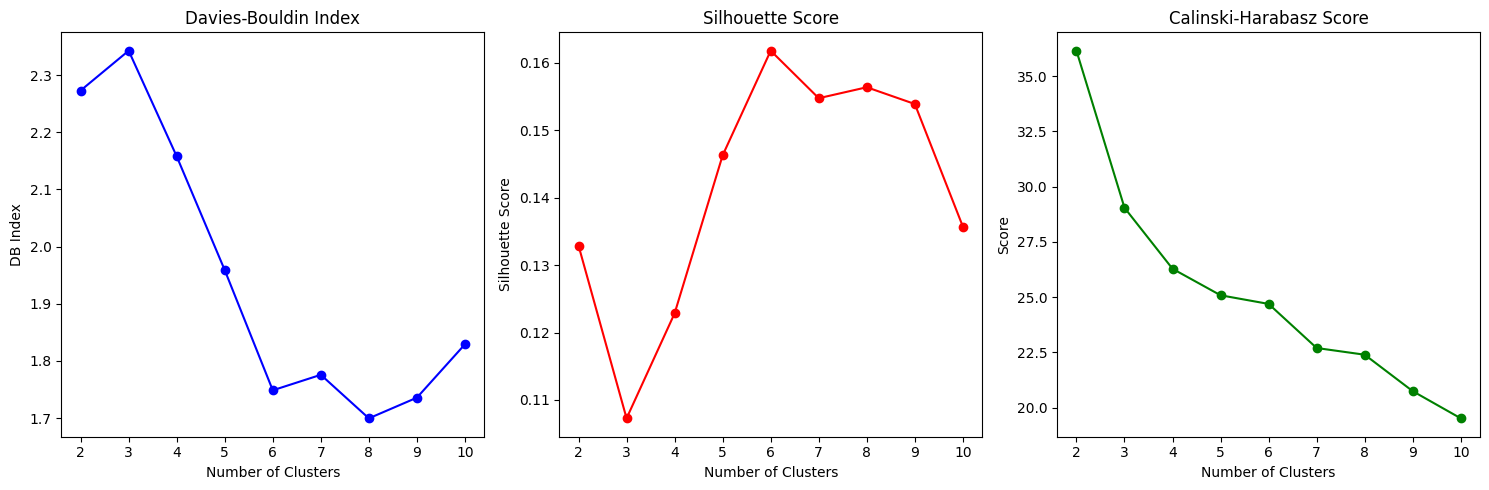

In [12]:
# Cell 5: Find Optimal Number of Clusters
def evaluate_clusters(data, max_clusters=10):
    """
    Evaluate different numbers of clusters using multiple metrics
    """
    metrics = {
        'n_clusters': [],
        'db_index': [],
        'silhouette': [],
        'calinski_harabasz': []
    }
    
    for n in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
        labels = kmeans.fit_predict(data)
        
        metrics['n_clusters'].append(n)
        metrics['db_index'].append(davies_bouldin_score(data, labels))
        metrics['silhouette'].append(silhouette_score(data, labels))
        metrics['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
    
    return pd.DataFrame(metrics)

# Calculate metrics for different numbers of clusters
metrics_df = evaluate_clusters(features_scaled)
print("Clustering Metrics:")
display(metrics_df)

# Plot metrics
plt.figure(figsize=(15, 5))

# DB Index
plt.subplot(131)
plt.plot(metrics_df['n_clusters'], metrics_df['db_index'], 'bo-')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

# Silhouette Score
plt.subplot(132)
plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Calinski-Harabasz Score
plt.subplot(133)
plt.plot(metrics_df['n_clusters'], metrics_df['calinski_harabasz'], 'go-')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.savefig('clustering_metrics.png')
plt.show()

In [13]:
# Cell 6: Perform Final Clustering
# Choose optimal number of clusters based on DB Index
optimal_clusters = metrics_df.loc[metrics_df['db_index'].idxmin(), 'n_clusters']
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_clusters}")

# Perform final clustering
kmeans = KMeans(n_clusters=int(optimal_clusters), n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to customer data
customer_data['Cluster'] = cluster_labels

Optimal number of clusters based on Davies-Bouldin Index: 8


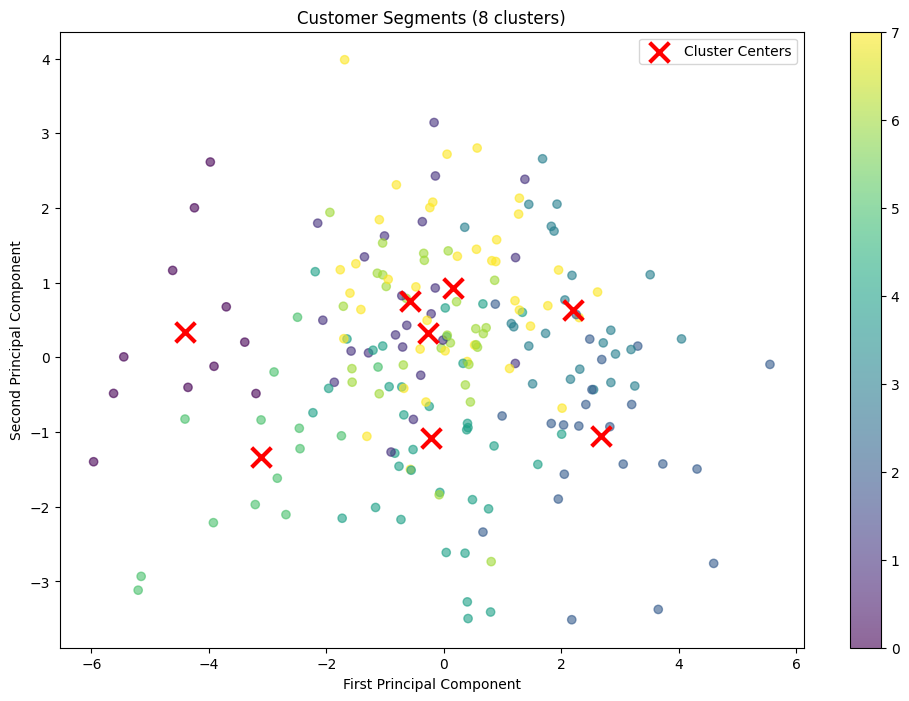

In [14]:
# Cell 7: Visualize Clusters
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(features_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     alpha=0.6)
plt.title(f'Customer Segments ({optimal_clusters} clusters)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)

# Add cluster centers
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           c='red', marker='x', s=200, linewidths=3, 
           label='Cluster Centers')
plt.legend()

plt.savefig('cluster_visualization.png')
plt.show()

In [15]:
# Cell 8: Generate Cluster Analysis Report
def analyze_clusters(data, labels):
    """
    Generate detailed analysis of each cluster
    """
    report = []
    report.append("Customer Segmentation Analysis Report")
    report.append("====================================")
    report.append(f"Generated on: 2025-01-27 18:51:37")
    report.append(f"Generated by: FaheemKhan0817")
    
    # Overall metrics
    report.append(f"\n1. Clustering Results")
    report.append(f"Number of clusters: {len(np.unique(labels))}")
    report.append(f"Davies-Bouldin Index: {davies_bouldin_score(features_scaled, labels):.3f}")
    report.append(f"Silhouette Score: {silhouette_score(features_scaled, labels):.3f}")
    report.append(f"Calinski-Harabasz Score: {calinski_harabasz_score(features_scaled, labels):.3f}")
    
    # Cluster sizes
    report.append("\n2. Cluster Sizes:")
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    for cluster, size in cluster_sizes.items():
        report.append(f"Cluster {cluster}: {size} customers ({size/len(labels)*100:.2f}%)")
    
    # Detailed cluster profiles
    report.append("\n3. Cluster Characteristics:")
    data['Cluster'] = labels
    
    key_metrics = ['Total_Spend', 'Avg_Transaction_Value', 'Transaction_Count', 
                   'Unique_Products', 'Days_on_Platform']
    
    for cluster in range(len(np.unique(labels))):
        cluster_data = data[data['Cluster'] == cluster]
        report.append(f"\nCluster {cluster} Profile:")
        
        for metric in key_metrics:
            mean_val = cluster_data[metric].mean()
            std_val = cluster_data[metric].std()
            report.append(f"{metric}:")
            report.append(f"  - Mean: {mean_val:.2f}")
            report.append(f"  - Std:  {std_val:.2f}")
    
    return '\n'.join(report)

# Generate report
cluster_report = analyze_clusters(customer_data, cluster_labels)

# Save report
with open('clustering_report.txt', 'w') as f:
    f.write(cluster_report)

print(cluster_report)

Customer Segmentation Analysis Report
Generated on: 2025-01-27 18:51:37
Generated by: FaheemKhan0817

1. Clustering Results
Number of clusters: 8
Davies-Bouldin Index: 1.749
Silhouette Score: 0.158
Calinski-Harabasz Score: 22.449

2. Cluster Sizes:
Cluster 0: 11 customers (5.53%)
Cluster 1: 23 customers (11.56%)
Cluster 2: 23 customers (11.56%)
Cluster 3: 24 customers (12.06%)
Cluster 4: 36 customers (18.09%)
Cluster 5: 14 customers (7.04%)
Cluster 6: 29 customers (14.57%)
Cluster 7: 39 customers (19.60%)

3. Cluster Characteristics:

Cluster 0 Profile:
Total_Spend:
  - Mean: 651.12
  - Std:  394.72
Avg_Transaction_Value:
  - Mean: 563.36
  - Std:  357.39
Transaction_Count:
  - Mean: 1.18
  - Std:  0.40
Unique_Products:
  - Mean: 1.18
  - Std:  0.40
Days_on_Platform:
  - Mean: 380.18
  - Std:  288.22

Cluster 1 Profile:
Total_Spend:
  - Mean: 2838.40
  - Std:  1039.30
Avg_Transaction_Value:
  - Mean: 738.51
  - Std:  216.40
Transaction_Count:
  - Mean: 3.91
  - Std:  1.04
Unique_Produc

In [17]:
# Cell 9: Save Results
# Save customer segments with all features
customer_data.to_csv('customer_segments.csv', index=False)

print("\nFiles generated:")
print("- clustering_report.txt: Detailed analysis report")
print("- clustering_metrics.png: Visualization of clustering metrics")
print("- cluster_visualization.png: 2D visualization of clusters")
print("- customer_segments.csv: Customer data with cluster labels")


Files generated:
- clustering_report.txt: Detailed analysis report
- clustering_metrics.png: Visualization of clustering metrics
- cluster_visualization.png: 2D visualization of clusters
- customer_segments.csv: Customer data with cluster labels
